In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import pdb
from glob import glob
from neurosim.models.ssr import StateSpaceRealization as SSR
import sys

In [3]:
sys.path.append('../..')

In [4]:
from utils import apply_df_filters

### Consolidate

In [4]:
# Consolidate
rfiles = glob('/home/akumar/nse/neural_control/mpi_test/*.dat')

In [5]:
master_list = []
for file in rfiles:
    with open(file, 'rb') as f:
        results = pickle.load(f)
        master_list.append(results)

### Plotting

In [8]:
with open('mpi_em_results.dat', 'rb') as f:
    master_list1 = pickle.load(f)
    master_list2 = pickle.load(f)

In [42]:
result_df = pd.DataFrame(master_list1)

In [43]:
result_df.keys()

Index(['fold_idx', 'N', 'trajectory_rep', 'model_rep', 'true_params',
       'autocorr_true', 'autocorr_train', 'autocorr_test', 'model_order',
       'ssid_coef', 'MLcoef', 'coef'],
      dtype='object')

In [44]:
# Key thing to test: What is the cross-validated error in estimation of the cross correlation matrices?
N = np.unique(result_df['N'].values)
trajectory_rep = np.unique(result_df['trajectory_rep'].values)
model_order = np.unique(result_df['model_order'].values)

In [45]:
model_order

array([15, 17, 19, 21, 23, 25])

In [12]:
ssid_error1 = np.zeros((N.size, trajectory_rep.size, model_order.size, 5, 5))
ssid_error2 = np.zeros((N.size, trajectory_rep.size, model_order.size, 5, 5))
stable_em_error = np.zeros((N.size, trajectory_rep.size, model_order.size, 5, 5))

In [13]:
def autocorrelation1(A, C, Q, R, S, T):

    autocorr = np.zeros((T, C.shape[0], C.shape[0]))

    P = scipy.linalg.solve_discrete_lyapunov(A, Q)

    autocorr[0, ...] = C @ P @ C.T + R

    # Construct Cbar from A, P, C, and S
    Cbar = C @ P @ A.T + S.T

    for i in range(1, T):
        autocorr[i, ...] = C @ np.linalg.matrix_power(A, i - 1) @ Cbar.T
    return autocorr 


In [14]:
def autocorrelation2(A, C, Cbar, Q, R, T):

    autocorr = np.zeros((T, C.shape[0], C.shape[0]))

    P = scipy.linalg.solve_discrete_lyapunov(A, Q)

    autocorr[0, ...] = C @ P @ C.T + R

    for i in range(1, T):
        autocorr[i, ...] = C @ np.linalg.matrix_power(A, i - 1) @ Cbar.T
    return autocorr 

In [15]:
for i, n in enumerate(N):
    for j in trajectory_rep:
        for k, order in enumerate(model_order):
            df_ = apply_df_filters(result_df, N=n, trajectory_rep=j, model_order=order)
            for fold_idx in range(5):
                ssid_params = df_.iloc[fold_idx]['ssid_coef']
                ml_params = df_.iloc[fold_idx]['MLcoef']

                ccm_ssid1 = autocorrelation1(ssid_params[0], ssid_params[1], ssid_params[4], ssid_params[5], ssid_params[6], 5)
                ccm_ssid2 = autocorrelation2(ssid_params[0], ssid_params[1], ssid_params[2], ssid_params[4], ssid_params[5], 5)

                ccm_test = df_.iloc[fold_idx]['autocorr_test']
                ssid_error1[i, j, k, fold_idx, :] = [np.linalg.norm(ccm_test[idx] - ccm_ssid1[idx]) for idx in range(5)]
                ssid_error2[i, j, k, fold_idx, :] = [np.linalg.norm(ccm_test[idx] - ccm_ssid2[idx]) for idx in range(5)]


                if type(ml_params) == tuple:
                    ccm_ml = autocorrelation1(ml_params[0], ml_params[1], np.eye(ml_params[0].shape[0]), ml_params[2], np.zeros((ml_params[0].shape[0], ml_params[1].shape[0])), 5)
                    stable_em_error[i, j, k, fold_idx, :] = [np.linalg.norm(ccm_test[idx] - ccm_ml[idx]) for idx in range(5)]
                else:
                    stable_em_error[i, j, k, fold_idx, :] = np.nan


/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


In [16]:
model_order

array([15, 17, 19, 21, 23, 25])

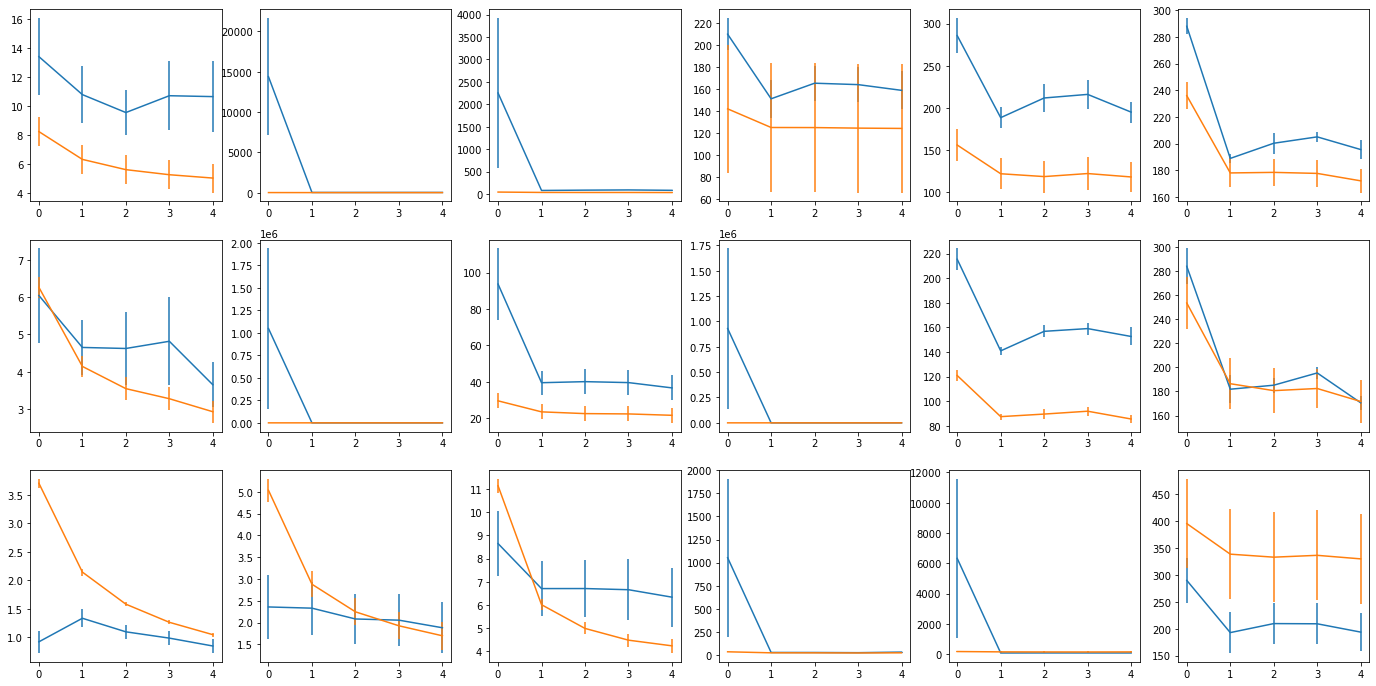

In [17]:
# Plots 

# Average cross folds. Each subplot is for a different N anbd model_order combination
fig, ax = plt.subplots(N.size, model_order.size, figsize=(4*model_order.size, 4*N.size))
for i in range(N.size):
    for j in range(model_order.size):
        # y1 = np.nanmean(np.nanmean(ssid_error1[i, :, j, ...], axis=0), axis=0)
        # y1st = np.nanstd(np.nanstd(ssid_error1[i, :, j, ...], axis=0), axis=0)/np.sqrt(50)

        y2 = np.nanmean(np.nanmean(ssid_error2[i, :, j, ...], axis=0), axis=0)
        y2st = np.nanstd(np.nanstd(ssid_error2[i, :, j, ...], axis=0), axis=0)/np.sqrt(50)

        y3 = np.nanmean(np.nanmean(stable_em_error[i, :, j, ...], axis=0), axis=0)
        y3st = np.nanstd(np.nanstd(stable_em_error[i, :, j, ...], axis=0), axis=0)/np.sqrt(50)

        # ax[i, j].errorbar(np.arange(5), y1, yerr=y1st)
        ax[i, j].errorbar(np.arange(5), y2, yerr=y2st)
        ax[i, j].errorbar(np.arange(5), y3, yerr=y3st)


In [48]:
result_df = pd.DataFrame(master_list2)

In [49]:
result_df.keys()

Index(['fold_idx', 'N', 'trajectory_rep', 'model_rep', 'true_params',
       'autocorr_true', 'autocorr_train', 'autocorr_test', 'model_order',
       'ols_coef', 'uoi_coef'],
      dtype='object')

In [50]:
# Key thing to test: What is the cross-validated error in estimation of the cross correlation matrices?
N = np.unique(result_df['N'].values)
trajectory_rep = np.unique(result_df['trajectory_rep'].values)
var_order = np.unique(result_df['model_order'].values)

In [24]:
ols_error = np.zeros((N.size, trajectory_rep.size, model_order.size, 5, 5))
uoi_error = np.zeros((N.size, trajectory_rep.size, model_order.size, 5, 5))

In [26]:
from neurosim.models.var import VAR as VARss

In [27]:
for i, n in enumerate(N):
    for j in trajectory_rep:
        for k, order in enumerate(model_order):
            df_ = apply_df_filters(result_df, N=n, trajectory_rep=j, model_order=order)
            for fold_idx in range(5):
                ols_coef = df_.iloc[fold_idx]['ols_coef']
                uoi_coef = df_.iloc[fold_idx]['uoi_coef']

                ccm_ols = VARss(ols_coef).autocorrelation(5)
                ccm_uoi = VARss(uoi_coef).autocorrelation(5)

                ccm_test = df_.iloc[fold_idx]['autocorr_test']
                ols_error[i, j, k, fold_idx, :] = [np.linalg.norm(ccm_test[idx] - ccm_ols[idx]) for idx in range(5)]
                uoi_error[i, j, k, fold_idx, :] = [np.linalg.norm(ccm_test[idx] - ccm_uoi[idx]) for idx in range(5)]

In [31]:
ccm_ols.shape

(5, 10, 10)

In [ ]:
# Plots 

# Average cross folds. Each subplot is for a different N anbd model_order combination
fig, ax = plt.subplots(N.size, model_order.size, figsize=(4*model_order.size, 4*N.size))
for i in range(N.size):
    for j in range(model_order.size):
        # y1 = np.nanmean(np.nanmean(ssid_error1[i, :, j, ...], axis=0), axis=0)
        # y1st = np.nanstd(np.nanstd(ssid_error1[i, :, j, ...], axis=0), axis=0)/np.sqrt(50)


        # ax[i, j].errorbar(np.arange(5), y1, yerr=y1st)
        ax[i, j].errorbar(np.arange(5), y2, yerr=y2st)
        ax[i, j].errorbar(np.arange(5), y3, yerr=y3st)


In [46]:
model_order

array([15, 17, 19, 21, 23, 25])

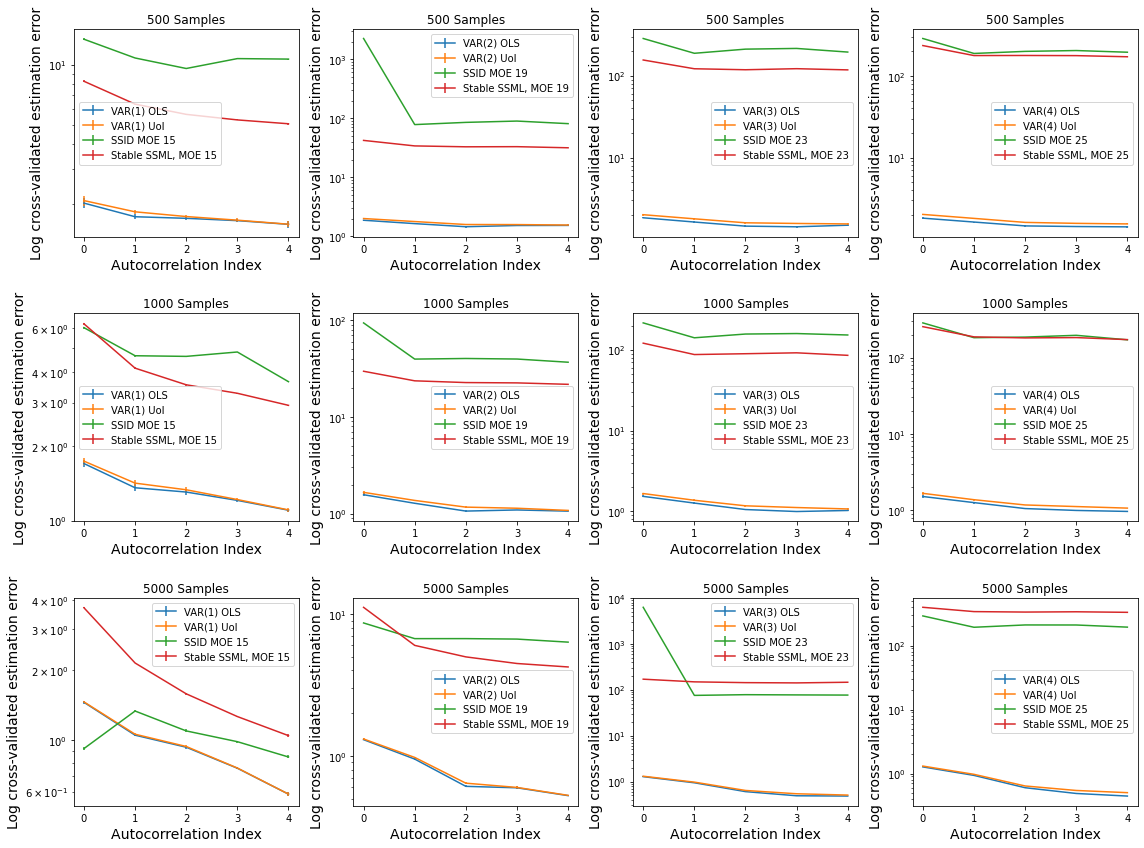

In [59]:
# Plots 
idx_map = [0, 2, 4, 5]
# Average cross folds. Each subplot is for a different N anbd model_order combination
fig, ax = plt.subplots(N.size, var_order.size, figsize=(4*var_order.size, 4*N.size))
for i in range(N.size):
    for j in range(var_order.size):

        y2 = np.nanmean(np.nanmean(ols_error[i, :, j, ...], axis=0), axis=0)
        y2st = np.nanstd(np.nanstd(ols_error[i, :, j, ...], axis=0), axis=0)

        y3 = np.nanmean(np.nanmean(uoi_error[i, :, j, ...], axis=0), axis=0)
        y3st = np.nanstd(np.nanstd(uoi_error[i, :, j, ...], axis=0), axis=0)

        y4 = np.nanmean(np.nanmean(ssid_error2[i, :, idx_map[j], ...], axis=0), axis=0)
        y4st = np.nanstd(np.nanstd(ssid_error2[i, :, idx_map[j], ...], axis=0), axis=0)
        y5 = np.nanmean(np.nanmean(stable_em_error[i, :, idx_map[j], ...], axis=0), axis=0)
        y5st = np.nanstd(np.nanstd(stable_em_error[i, :, idx_map[j], ...], axis=0), axis=0)
        ax[i, j].errorbar(np.arange(5), y2, yerr=y2st)
        ax[i, j].errorbar(np.arange(5), y3, yerr=y3st)
        ax[i, j].errorbar(np.arange(5), y4, yerr=y2st)
        ax[i, j].errorbar(np.arange(5), y5, yerr=y3st)
        ax[i, j].set_yscale('log')

        ax[i, j].set_xlabel('Autocorrelation Index', fontsize=14)
        ax[i, j].set_ylabel('Log cross-validated estimation error', fontsize=14)
        ax[i, j].set_title('%d Samples' % N[i])
        ax[i, j].legend(['VAR(%d) OLS' % var_order[j], 'VAR(%d) UoI' % var_order[j],
                         'SSID MOE %d' % model_order[idx_map[j]], 'Stable SSML, MOE %d' % model_order[idx_map[j]]])
fig.tight_layout()
fig.savefig('CV_ccmerror.pdf', bbox_inches='tight', pad_inches=0)